# **Устанавливаем библиотеки**

In [0]:
!pip3 install torch
!pip3 install pandas
!pip3 install scikit-learn

In [0]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
%matplotlib inline


# **Обрабатываем данные**

Загружаем и обрабатываем данные

In [0]:
df = pd.read_csv('/content/transport_data.csv',header=0,sep=',')

In [0]:
data = df[(df.label != '-') & (df.label != '?')].iloc[:,[0,1,2,3]]

In [0]:
target = df[(df.label != '-') & (df.label != '?')].iloc[:,[4]]
target = target.apply(pd.to_numeric)

In [0]:
test = df[(df.label == '?')].iloc[:,[0,1,2,3]]

In [0]:
data.trans_ts = pd.to_datetime(data.trans_ts, unit='s')
data.request_ts = pd.to_datetime(data.request_ts, unit='s')

data['trans_ts_d'] = data.trans_ts.dt.dayofweek
data['trans_ts_h'] = data.trans_ts.dt.hour
data['trans_ts_m'] = data.trans_ts.dt.minute
data['trans_ts_s'] = data.trans_ts.dt.second



data = data.drop('trans_ts', axis = 1)

data['dayofweek_request_ts'] = data.request_ts.dt.dayofweek
data['hour_request_ts'] = data.request_ts.dt.hour
data['minute_request_ts'] = data.request_ts.dt.minute
data['request_ts_s'] = data.request_ts.dt.second

data = data.drop('request_ts', axis = 1)


test.trans_ts = pd.to_datetime(test.trans_ts, unit='s')
test.request_ts = pd.to_datetime(test.request_ts, unit='s')

test['trans_ts_d'] = test.trans_ts.dt.dayofweek
test['trans_ts_h'] = test.trans_ts.dt.hour
test['trans_ts_m'] = test.trans_ts.dt.minute
test['trans_ts_s'] = test.trans_ts.dt.second



test = test.drop('trans_ts', axis = 1)

test['dayofweek_request_ts'] = test.request_ts.dt.dayofweek
test['hour_request_ts'] = test.request_ts.dt.hour
test['minute_request_ts'] = test.request_ts.dt.minute
test['request_ts_s'] = test.request_ts.dt.second

test = test.drop('request_ts', axis = 1)

# **Через scikit**

Используем в ансамбле 3 метода

In [0]:
classifiers_ensemble = [
    RandomForestClassifier(n_estimators=300, max_features=None, n_jobs=-1, max_depth=100, random_state=8),
    AdaBoostClassifier(n_estimators=200),
    ExtraTreesClassifier(n_estimators=300, max_features=None, n_jobs=-1)
    ]

Обучаемся и выбираем лучшие предсказания

In [0]:
check = True

for classifier in classifiers_ensemble:
  classifier.fit(data, target)
  if (check == True):
    predictions = classifier.predict(test)
    check = False
  else:
    predictions = np.vstack((predictions,classifier.predict(test)))

prediction = []
for i in range(len(predictions[0])):
  predLab0 = 0
  predLab1 = 0
  predLab2 = 0
  for j in range(len(predictions)):
    if predictions[j][i] == 0:
        predLab0 = predLab0 + 1
    if predictions[j][i] == 1:
        predLab1 = predLab1 + 1
    if predictions[j][i] == 2:
        predLab2 = predLab2 + 1

  if ((predLab0 >= predLab1) and (predLab0 >= predLab2)):
    prediction = prediction + [0]
  else:
    if ((predLab1 >= predLab0) and (predLab1 >= predLab2)):
      prediction = prediction + [1]
    else:
      prediction = prediction + [2]



Рассмотрим наши предсказания на графике

<class 'list'>
torch.Size([1, 697])
torch.Size([1, 1771])
torch.Size([1, 2532])


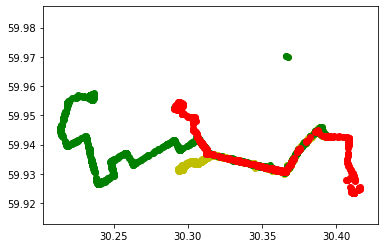

In [0]:
test = np.array(test)
print(type(prediction))
prediction = np.array(prediction)
indices0 = torch.tensor(np.where(prediction == 0))
indices1 = torch.tensor(np.where(prediction == 1))
indices2 = torch.tensor(np.where(prediction == 2))
print(indices2.shape)
print(indices1.shape)
print(indices0.shape)

plt.scatter(test[indices0[0],[0]],test[indices0,[1]],c='y')
plt.scatter(test[indices1,[0]],test[indices1,[1]],c='g')
plt.scatter(test[indices2,[0]],test[indices2,[1]],c='r')

In [0]:
np.savetxt('predwithout.txt', prediction, fmt="%s")

Отсортируем геометрически

In [0]:
k = 0
for i in range(test.shape[0]):
  if ((test[i][0] <= 30.285)|(test[i][1] >= 59.936)&(test[i][1] <= 59.945)&(test[i][0] <= 30.303)|(test[i][1] >= 59.965)):
    prediction[i] = 1
  elif ((test[i][0] >= 30.397)|(test[i][1] >= 59.945)):
    prediction[i] = 2
  elif ((test[i][1] <= 59.9347)&(test[i][0] <= 30.31)):
    prediction[i] = 0
    

torch.Size([1, 730])
torch.Size([1, 1755])
torch.Size([1, 2515])


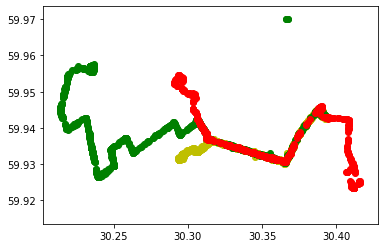

In [0]:
indices0 = torch.tensor(np.where(prediction == 0))
indices1 = torch.tensor(np.where(prediction == 1))
indices2 = torch.tensor(np.where(prediction == 2))
print(indices2.shape)
print(indices1.shape)
print(indices0.shape)

plt.scatter(test[indices0[0],[0]],test[indices0,[1]],c='y')
plt.scatter(test[indices1,[0]],test[indices1,[1]],c='g')
plt.scatter(test[indices2,[0]],test[indices2,[1]],c='r')

In [0]:
np.savetxt('prediction.txt', prediction, fmt="%s")